## Homework 05:

## Due Date: Mar 15, 2021, 4:00pm

#### Firstname Lastname: WenxinZhang

#### E-mail: wz2164@nyu.edu

#### Enter your solutions and submit this notebook

---

### Part of Lecture 04

---

In [1]:
from itertools import product
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
def build_grid(n):
    '''defines the grid'''
    G = np.zeros((n, n))
    return G


def set_boundary_grid(G):
    '''set the boundary values'''
    n = G.shape[0]
    G[:,  0] = 1.0
    G[0,  :] = 1.0
    G[-1, :] = 1.0
    G[:, -1] = 1.0

    
def plot_grid(G):
    img = plt.imshow(G)
    img.set_cmap('rainbow')
    plt.axis('off')
    plt.show()

    
# using iterators to traverse the grid
def iteration_gen(G):
    n = G.shape[0]
    indices = product(range(1, n-1), repeat=2)
    for e in indices:
        G[e]=(G[e[0] + 1, e[1]] + G[e[0] - 1, e[1]] + G[e[0], e[1] + 1] + G[e[0], e[1] - 1])/4
    

# using numpy built-in functions to compute the error
def calc_error_np(G1, G2):
    error = np.square(np.subtract(G1, G2)).mean()
    return(error)


# deep copy of G1 to G2
def copy_array(G1, G2):
    G2[:, :] = G1[:, :]

    
def solve_heat_equation4(n):
    '''changing to both calc_error_np and iteration_gen functions'''
    G = build_grid(n)
    set_boundary_grid(G)
    
    G_prev = build_grid(n)
    copy_array(G, G_prev)
    
    error = np.float("inf")
    while error > 1e-7:
        iteration_gen(G)
        error = calc_error_np(G, G_prev) 
        copy_array(G, G_prev)          
    return(G)

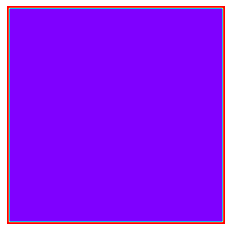

In [3]:
size_of_grid = 100
G = build_grid(n=size_of_grid)
set_boundary_grid(G)
plot_grid(G) 

In [4]:
%load_ext line_profiler
%lprun -f solve_heat_equation4 G4 = solve_heat_equation4(size_of_grid)

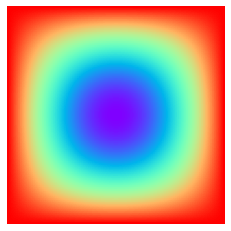

In [5]:
plot_grid(G4)


---

# Problem 1. (100 points)


In Lecture 04 we considered the heat equation over a homogeneous material for which an iteration is given by the following equation:
$$
f_{i,j} = \frac{f_{i+1,j}+f_{i-1,j} + f_{i,j+1} + f_{i,j-1}}{4} \,.
$$

This was implemented by: 
```
# using iterators to traverse the grid
def iteration_gen(G):
"""the iteration function from lect04"""
    n = G.shape[0]
    indices = product(range(1, n-1), repeat=2)
    for e in indices:
        G[e]=(G[e[0] + 1, e[1]] + G[e[0] - 1, e[1]] + G[e[0], e[1] + 1] + G[e[0], e[1] - 1])/4
```


----

Now imagine, you are given a non-homogeneous material for which the iteration, i.e. the corresponding equation,  depends on the position $(i, j)$ and is given by:
$$
f_{i,j} := \frac{ h_{i + 1,j} f_{i + 1, j} + h_{i - 1,j} f_{i - 1,j} + h_{i,j + 1} f_{i,j+1} + h_{i,j - 1} f_{i,j-1}}{ h_{i + 1,j} + h_{i - 1,j} + h_{i,j + 1} + h_{i,j - 1} } \,.
$$
Here "weight"
$$h(i, j) = \exp\left(-\frac{|i - j|} {\sqrt{n}}\right) \,,$$
corresponds to the point $(i, j)$, where $n$ is the size of the grid.

----

Write a new function:
```
def iteration_gen_nonhomogeneous(G):
    """the iteration function in hw05"""
```
to solve the non-homogeneous case defined as above. 


The task here is to examine run-time improvements that can be obtained by Cython for this non-homogeneous material. Consider **solve_heat_equation4** from Lect04, which now becomes.

```
def solve_heat_nonhomogeneous_equation4(n):
    '''changing to both calc_error_np and iteration_gen functions'''
    G = build_grid(n)
    set_boundary_grid(G)
    
    G_prev = build_grid(n)
    copy_array(G, G_prev)
    
    error = np.float("inf")
    while error > 1e-7:
        iteration_gen_nonhomogeneous(G)
        error = calc_error_np(G, G_prev) 
        copy_array(G, G_prev)          
    return(G)
```

----

Concretely, as presented in Lect05, perform the following steps and measure their run-times:

(i) simply compile the python code with Cython, without any changes;


(ii) introduce variables and arrays with ctypes (by using the command cdef);  


(iii) besides (ii), also use the content of ndarray objects in order to efficiently access the data buffer of the arrays.

---

In the sequel of the notebook, as your solution, submit codes, run-times, and plots of the following tasks:

**2.1 (30pt)** solve_heat_nonhomogeneous_equation4(100)

**2.2 (10pt)** solve_heat_nonhomogeneous_equation4(100) when applied (i)  

**2.3 (30pt)** solve_heat_nonhomogeneous_equation4(100) when applied (ii)  

**2.4 (30pt)** solve_heat_nonhomogeneous_equation4(100) when applied (iii)  

Notice that to obtain a best performance for the heat equation you also need to apply (i), (ii), (iii) to the functions called within "solve_heat_equation4".


In [6]:
%load_ext Cython

In [7]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [8]:
size_of_grid = 100

### Part 1: solve_heat_equation4(100)

In [9]:
def iteration_gen_non_homogeneous(G):
    def h(i, j):
        return math.exp(-abs(i-j) / math.sqrt(size_of_grid))
    
    n = G.shape[0]
    indices = product(range(1, n-1), repeat=2)
    
    for e in indices:
        h1 = h(e[0]+1, e[1])
        h2 = h(e[0]-1, e[1])
        h3 = h(e[0], e[1]+1)
        h4 = h(e[0], e[1]-1)
        G[e] = (G[e[0]+1, e[1]]*h1 + G[e[0]-1, e[1]]*h2 + G[e[0], e[1]+1]*h3 + G[e[0], e[1]-1]*h4) / (h1+h2+h3+h4)


In [10]:
def solve_heat_nonhomogeneous_equation4(n):
    G = build_grid(n)
    set_boundary_grid(G)

    G_prev = build_grid(n)
    copy_array(G, G_prev)

    error = np.float("inf")
    while error > 1e-7:
        iteration_gen_non_homogeneous(G)
        error = calc_error_np(G, G_prev) 
        copy_array(G, G_prev)   
        
    return(G)


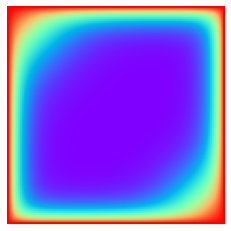

In [11]:
%lprun -f solve_heat_nonhomogeneous_equation4 G = solve_heat_nonhomogeneous_equation4(size_of_grid)
plot_grid(G)

### HERE COPY-PASTE THE OUTPUT FROM LINE-PROFILER:

Timer unit: 1e-06 s

- Total time: 20.0945 s
- File: <ipython-input-10-0dd788b1e33d>
- Function: solve_heat_nonhomogeneous_equation4 at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
<!-- ============================================================== -->
     1                                           def solve_heat_nonhomogeneous_equation4(n):
     2         1        104.0    104.0      0.0      G = build_grid(n)
     3         1         24.0     24.0      0.0      set_boundary_grid(G)
     4                                           
     5         1         94.0     94.0      0.0      G_prev = build_grid(n)
     6         1        124.0    124.0      0.0      copy_array(G, G_prev)
     7                                           
     8         1          4.0      4.0      0.0      error = np.float("inf")
     9       310        317.0      1.0      0.0      while error > 1e-7:
    10       309   20066028.0  64938.6     99.9          iteration_gen_non_homogeneous(G)
    11       309      24828.0     80.3      0.1          error = calc_error_np(G, G_prev) 
    12       309       2983.0      9.7      0.0          copy_array(G, G_prev)   
    13                                                   
    14         1          0.0      0.0      0.0      return(G)

### Part 2: solve_heat_equation4(100) after applying (i)


In [12]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [13]:
%%cython 
# cython: profile=True
# cython: linetrace=True
# cython: binding=True
# distutils: define_macros=CYTHON_TRACE_NOGIL=1


from itertools import product
import numpy as np
import matplotlib.pyplot as plt
import math


size_of_grid= 100


def build_grid(n):
    '''defines the grid'''
    G = np.zeros((n, n))
    return G


def set_boundary_grid(G):
    '''set the boundary values'''
    n = G.shape[0]
    G[:,  0] = 1.0
    G[0,  :] = 1.0
    G[-1, :] = 1.0
    G[:, -1] = 1.0

    
def plot_grid(G):
    img = plt.imshow(G)
    img.set_cmap('rainbow')
    plt.axis('off')
    plt.show()

    
# using iterators to traverse the grid
def iteration_gen_non_homogeneous(G):
    def h(i, j):
        return math.exp(-abs(i-j) / math.sqrt(size_of_grid))
    
    n = G.shape[0]
    indices = product(range(1, n-1), repeat=2)
    
    for e in indices:
        h1 = h(e[0]+1, e[1])
        h2 = h(e[0]-1, e[1])
        h3 = h(e[0], e[1]+1)
        h4 = h(e[0], e[1]-1)
        G[e] = (G[e[0]+1, e[1]]*h1 + G[e[0]-1, e[1]]*h2 + G[e[0], e[1]+1]*h3 + G[e[0], e[1]-1]*h4) / (h1+h2+h3+h4)
    
    
# using numpy built-in functions to compute the error
def calc_error_np(G1, G2):
    error = np.square(np.subtract(G1, G2)).mean()
    return error


# deep copy of G1 to G2
def copy_array(G1, G2):
    G2[:, :] = G1[:, :]

    
def solve_heat_nonhomogeneous_equation4(n):
    G = build_grid(n)
    set_boundary_grid(G)
    
    G_prev = build_grid(n)
    copy_array(G, G_prev)

    error = np.float("inf")
    while error > 1e-7:
        iteration_gen_non_homogeneous(G)
        error = calc_error_np(G, G_prev) 
        copy_array(G, G_prev)   
        
    return G


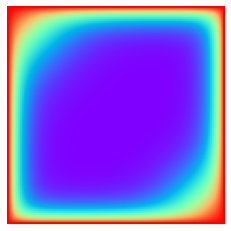

In [14]:
%lprun -f solve_heat_nonhomogeneous_equation4 G = solve_heat_nonhomogeneous_equation4(100)
plot_grid(G)

### HERE COPY-PASTE THE OUTPUT FROM LINE-PROFILER:

Timer unit: 1e-06 s

- Total time: 10.1422 s
- File: /Users/wenxinzhang/.ipython/cython/_cython_magic_5b5f83e109c2af41ccb5c3c5ace45087.pyx
- Function: solve_heat_nonhomogeneous_equation4 at line 64

Line #      Hits         Time  Per Hit   % Time  Line Contents
<!-- ============================================================== -->
    64                                           def solve_heat_nonhomogeneous_equation4(n):
    65         1         25.0     25.0      0.0      G = build_grid(n)
    66         1         15.0     15.0      0.0      set_boundary_grid(G)
    67                                               
    68         1          9.0      9.0      0.0      G_prev = build_grid(n)
    69         1        110.0    110.0      0.0      copy_array(G, G_prev)
    70                                           
    71         1          4.0      4.0      0.0      error = np.float("inf")
    72         1          1.0      1.0      0.0      while error > 1e-7:
    73       309   10114270.0  32732.3     99.7          iteration_gen_non_homogeneous(G)
    74       309      25038.0     81.0      0.2          error = calc_error_np(G, G_prev) 
    75       309       2691.0      8.7      0.0          copy_array(G, G_prev)   
    76                                                   
    77         1          3.0      3.0      0.0      return G

### Part 3: solve_heat_equation4(100) after applying (ii)

In [15]:
%%cython
# cython: profile=True
# cython: linetrace=True
# cython: binding=True
# distutils: define_macros=CYTHON_TRACE_NOGIL=1


from itertools import product
import numpy as np
import matplotlib.pyplot as plt
cimport numpy as np
import math


cdef int size_of_grid = 100


def build_grid(int n):
    '''defines the grid'''
    cdef np.ndarray G = np.zeros((n, n))
    return G
    

def set_boundary_grid(np.ndarray G):
    '''set the boundary values'''
    cdef int n = G.shape[0]
    G[:,  0] = 1.0
    G[0,  :] = 1.0
    G[-1, :] = 1.0
    G[:, -1] = 1.0


def plot_grid(np.ndarray G):
    img = plt.imshow(G)
    img.set_cmap('rainbow')
    plt.axis('off')
    plt.show()
    
    
# using iterators to traverse the grid
def iteration_gen_nonhomogeneous(np.ndarray G):
    def h(i, j):
        return math.exp(-abs(i-j) / math.sqrt(size_of_grid))
    
    cdef int n = G.shape[0]
    indices = product(range(1, n-1), repeat=2)
    
    cdef (int,int) e 
    for e in indices:
        h1 = h(e[0]+1, e[1])
        h2 = h(e[0]-1, e[1])
        h3 = h(e[0], e[1]+1)
        h4 = h(e[0], e[1]-1)
        G[e] = (G[e[0]+1, e[1]]*h1 + G[e[0]-1, e[1]]*h2 + G[e[0], e[1]+1]*h3 + G[e[0], e[1]-1]*h4) / (h1+h2+h3+h4)
        
        
# using numpy built-in functions to compute the error
def calc_error_np(np.ndarray G1, np.ndarray G2):
    cdef float error = np.square(np.subtract(G1, G2)).mean()
    return error


# deep copy of G1 to G2
def copy_array(np.ndarray G1, np.ndarray G2):
    G2[:, :] = G1[:, :]
    
    
def solve_heat_nonhomogeneous_equation4(int n):
    '''changing to both calc_error_np and iteration_gen functions'''
    
    cdef np.ndarray G = build_grid(n)
    set_boundary_grid(G)

    cdef np.ndarray G_prev = build_grid(n)
    copy_array(G, G_prev)

    cdef float error = np.float("inf")
    while error > 1e-7:
        iteration_gen_nonhomogeneous(G)
        error = calc_error_np(G, G_prev) 
        copy_array(G, G_prev)  
        
    return G


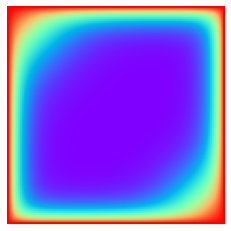

In [16]:
%lprun -f solve_heat_nonhomogeneous_equation4 G = solve_heat_nonhomogeneous_equation4(100)
plot_grid(G)

### HERE COPY-PASTE THE OUTPUT FROM LINE-PROFILER:

Timer unit: 1e-06 s

- Total time: 10.167 s
- File: /Users/wenxinzhang/.ipython/cython/_cython_magic_d51008907eda9d4594471c9a4c435de0.pyx
- Function: solve_heat_nonhomogeneous_equation4 at line 67

Line #      Hits         Time  Per Hit   % Time  Line Contents
<!-- ============================================================== -->
    67                                           def solve_heat_nonhomogeneous_equation4(int n):
    68                                               '''changing to both calc_error_np and iteration_gen functions'''
    69                                               
    70         1         24.0     24.0      0.0      cdef np.ndarray G = build_grid(n)
    71         1         15.0     15.0      0.0      set_boundary_grid(G)
    72                                           
    73         1         13.0     13.0      0.0      cdef np.ndarray G_prev = build_grid(n)
    74         1         15.0     15.0      0.0      copy_array(G, G_prev)
    75                                           
    76         1          3.0      3.0      0.0      cdef float error = np.float("inf")
    77         1          0.0      0.0      0.0      while error > 1e-7:
    78       309   10140966.0  32818.7     99.7          iteration_gen_nonhomogeneous(G)
    79       309      23598.0     76.4      0.2          error = calc_error_np(G, G_prev) 
    80       309       2406.0      7.8      0.0          copy_array(G, G_prev)  
    81                                                   
    82         1          1.0      1.0      0.0      return G

### Part 4: solve_heat_equation4(100) after applying (iii)

In [19]:
%%cython
# cython: profile=True
# cython: linetrace=True
# cython: binding=True
# distutils: define_macros=CYTHON_TRACE_NOGIL=1


from itertools import product
import numpy as np
import matplotlib.pyplot as plt
cimport numpy as np
import math


cdef int size_of_grid = 100


def build_grid(int n):
    '''defines the grid'''
    cdef np.ndarray[double, ndim=2] G = np.zeros((n, n))
    return G
    

def set_boundary_grid(np.ndarray[double, ndim=2] G):
    '''set the boundary values'''
    cdef int n = G.shape[0]
    G[:,  0] = 1.0
    G[0,  :] = 1.0
    G[-1, :] = 1.0
    G[:, -1] = 1.0


def plot_grid(np.ndarray[double, ndim=2] G):
    img = plt.imshow(G)
    img.set_cmap('rainbow')
    plt.axis('off')
    plt.show()
    
    
# using iterators to traverse the grid
def iteration_gen_nonhomogeneous(np.ndarray[double, ndim=2] G):
    def h(i, j):
        return math.exp(-abs(i-j) / math.sqrt(size_of_grid))
    
    cdef int n = G.shape[0]
    indices = product(range(1, n-1), repeat=2)
    
    cdef (int,int) e 
    for e in indices:
        h1 = h(e[0]+1, e[1])
        h2 = h(e[0]-1, e[1])
        h3 = h(e[0], e[1]+1)
        h4 = h(e[0], e[1]-1)
        G[e] = (G[e[0]+1, e[1]]*h1 + G[e[0]-1, e[1]]*h2 + G[e[0], e[1]+1]*h3 + G[e[0], e[1]-1]*h4) / (h1+h2+h3+h4)
        
        
# using numpy built-in functions to compute the error
def calc_error_np(np.ndarray[double, ndim=2] G1, np.ndarray[double, ndim=2] G2):
    cdef float error = np.square(np.subtract(G1, G2)).mean()
    return(error)


# deep copy of G1 to G2
def copy_array(np.ndarray[double, ndim=2] G1, np.ndarray[double, ndim=2] G2):
    G2[:, :] = G1[:, :]
    
    
def solve_heat_nonhomogeneous_equation4(int n):
    '''changing to both calc_error_np and iteration_gen functions'''
    
    cdef np.ndarray[double, ndim=2] G = build_grid(n)
    set_boundary_grid(G)

    cdef np.ndarray[double, ndim=2] G_prev = build_grid(n)
    copy_array(G, G_prev)

    cdef float error = np.float("inf")
    while error > 1e-7:
        iteration_gen_nonhomogeneous(G)
        error = calc_error_np(G, G_prev) 
        copy_array(G, G_prev)  
        
    return G


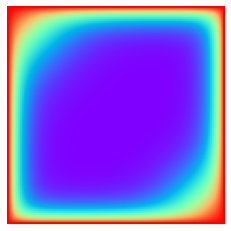

In [20]:
%lprun -f solve_heat_nonhomogeneous_equation4 G = solve_heat_nonhomogeneous_equation4(size_of_grid)
plot_grid(G)

### HERE COPY-PASTE THE OUTPUT FROM LINE-PROFILER:

Timer unit: 1e-06 s

- Total time: 6.22988 s
- File: /Users/wenxinzhang/.ipython/cython/_cython_magic_ffeca2e8ee79f5944fa96345a9cc309f.pyx
- Function: solve_heat_nonhomogeneous_equation4 at line 67

Line #      Hits         Time  Per Hit   % Time  Line Contents
<!-- ============================================================== -->
    67                                           def solve_heat_nonhomogeneous_equation4(int n):
    68                                               '''changing to both calc_error_np and iteration_gen functions'''
    69                                               
    70         1        363.0    363.0      0.0      cdef np.ndarray[double, ndim=2] G = build_grid(n)
    71         1         20.0     20.0      0.0      set_boundary_grid(G)
    72                                           
    73         1         60.0     60.0      0.0      cdef np.ndarray[double, ndim=2] G_prev = build_grid(n)
    74         1         96.0     96.0      0.0      copy_array(G, G_prev)
    75                                           
    76         1          4.0      4.0      0.0      cdef float error = np.float("inf")